In [3]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import pyproj
# 지도 시각화
import folium as g
from folium.plugins import MiniMap
from folium.plugins import MarkerCluster
import warnings
warnings.filterwarnings('ignore')
from haversine import haversine, Unit
#dbf
from dbfread import DBF
import seaborn as sns

## 변수
버스정류장, 노선, 출입구, 날씨, 백화점, 영화관, 행정동 단위 거주인구, 우수중소기업, 대학교, 중고등학교

## 그룹화를 해야하는 이유 - 논문
https://scienceon.kisti.re.kr/commons/util/originalView.do?cn=JAKO201912964890855&oCn=JAKO201912964890855&dbt=JAKO&journal=NJOU00025585
https://scienceon.kisti.re.kr/commons/util/originalView.do?cn=JAKO201827750146081&oCn=JAKO201827750146081&dbt=JAKO&journal=NJOU00560240

그룹 G0은 on1, on2나 off1,off2가 하루 중 넓게 분포하며, 이른 시간에는 나타나지 않는다. 저녁 시간에는 승차와 하차가 모두 발생한다. 
따라서 업무지역은 아니나 사람들의 이동이 많은 역임을 알 수 있다. 환승지역이나 상업지역이 많을 것으로 예상되는 역이다. 

그룹 G1은 승차와 하차가 이른 아침이나 저녁보다는 상대적으로 낮 시간대에 주로 발생한다.
그룹G1은 주거, 업무, 상업 어느 쪽으로도 구분하기 어려운 그룹이다.

그룹 G2는 on1이 오전 이른 시간, off2가 저녁 시간에 집중되어 있으므로 주거지임을 알 수 있다. 

그룹 G3은 off1이 오전 이른 시간에, on1이 저녁 시간에 집중되어 있으므로 업무지역임을 알 수 있다.

## 그룹화 - 그룹별 역

1. 역그룹0은 환승지역 또는 상업지역으로 볼 수 있다.

강변 개롱 개화산 건대입구 고덕 고려대 고속터미널
김포공항 노원 녹사평 당산 대치 독립문 동대문 동
대문운동장 동작 마장 마포구청 망원 모란 발산 사
당 상수 성신여대입구 송정 신당 신도림 신천 신촌
안암 약수 어린이대공원 영등포시장 오목교 올림픽
공원 왕십리 용두 월드컵경기장 이대 이수 이촌 이
태원 일원 잠실 장지 제기동 종합운동장 천호 청량
리 총신대입구 학여울 한성대입구 혜화 홍대입구

2. 역그룹1은 기타그룹으로 볼 수 있다.

가락시장 강동구청 공덕 광흥창 구로디지털단지
남구로 남태령 내방 대흥 도곡 도림천 디지털미디어시티
뚝섬 마곡 마포 매봉 몽촌토성 문래 문정 반포
방배 방이 버티고개 보라매 복정 상왕십리 서울역 
석촌 성수 송파 수서 숙대입구 신길 신설동 애오개 
양평 영등포구청 오금 장한평 청구 충정로 합정 효창
공원앞

3. 역그룹2는 주거지역

강동 거여 공릉 광나루 광명사거리 구산 구의 구파
발 군자 굽은다리 금호 길동 길음 까치산, 낙성대 남
성 남한산성입구 녹번 단대오거리 답십리 당고개 대
림 대청 도봉산 독바위 돌곶이 둔촌동 뚝섬유원지
마들 마천 먹골 면목 명일 목동 무악재 미아 미아삼
거리 방화 보문 봉천 봉화산 불광 사가정 산성 상계
상도 상봉 상월곡 상일동 새절 서울대입구 석계 성
내 수락산 수유 수진 숭실대입구 신금호 신답 신대
방 신대방삼거리 신림 신정 신정네거리 신풍 신흥
쌍문 아차산 아현 암사 양천구청 역촌 연신내 옥수
온수 용답 용마산 우장산 월곡 응암 잠원 장승배기
장암 중계 중곡 중화 증산 지축 창동 창신 철산 태릉
입구 하계 행당 홍제 화곡 화랑대

4. 역그룹3은 업무지역으로 볼 수 있다.

가산디지털단지 강남 강남구청 경복궁 광화문 교대
남부터미널 논현 동대문역사문화공원 동대입구 동
묘앞 명동 삼각지 삼성 서대문 서초 선릉 시청 신사
신용산 안국 압구정 양재 여의나루 여의도 역삼 을
지로3가 을지로4가 을지로입구 종각 종로3가 종로5
가 청담 충무로 학동 한강진 한양대 회현

## 데이터

In [5]:
# 파이썬 시각화 패키지 불러오기
import matplotlib.pyplot as plt
%matplotlib inline

# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [6]:
# 서울시 버스정류장 공간데이터 #EPSG:5186
bus = DBF('data/버스/2019/TB_E_BUSSTOP_2019.dbf')
bus = pd.DataFrame(bus)

In [7]:
# 서울시 행정동 단위 거주인구 데이터
population = pd.read_csv("data/서울시 행정동 단위 거주인구 데이터/TB_T_RSPOP_ADMI_21.csv")

In [5]:
# STATN데이터셋: 수도권 지하철 공간데이터(19년)
STATN19 = pd.read_csv("data/STATN19_df.csv")

In [6]:
# 데이터셋 불러오기

# subway데이터셋: 서울시 30분 단위 이용 통계(20~22년)
subway20 = pd.read_csv("data/subway20_df.csv")
subway21 = pd.read_csv("data/subway21_df.csv")
subway22 = pd.read_csv("data/subway22_df.csv")

# EXC데이터셋: 우수중소기업 공간데이터
EXC =  pd.read_csv("data/EXC_df.csv")

# TBVIATR데이터셋: 서울시 주요시설, 집객시설 주요데이터(20년)
TBVIATR = pd.read_csv("data/TBVIATR_df.csv")

# Seoul데이터셋: 서울시 지하철 시간대별 승객수(16~19년)
SEOUL17 = pd.read_csv("data/SEOUL17_df.csv")
SEOUL18 = pd.read_csv("data/SEOUL18_df.csv")
SEOUL19 = pd.read_csv("data/SEOUL19_df.csv")

# STATN데이터셋: 수도권 지하철 공간데이터(19년)
STATN19 = pd.read_csv("data/STATN19_df.csv")

# 서울시 버스정류장 공간데이터 #EPSG:5186
bus = DBF('data/버스/2019/TB_E_BUSSTOP_2019.dbf')
bus = pd.DataFrame(bus)

# 서울시 대학교 공간데이터
college = DBF('data/대학교 공간데이터/TL_UNIV_2020.dbf')
college = pd.DataFrame(college)

In [12]:
# 그룹화
group0 = pd.read_excel('data/그룹화/group0.xlsx')
group1 = pd.read_excel('data/그룹화/group1.xlsx')
group2 = pd.read_excel('data/그룹화/group2.xlsx')
group3 = pd.read_excel('data/그룹화/group3.xlsx')

,역명,사용일자,승차총승객수,하차총승객수,TM_X,TM_Y,노선수,출입구수
0,강동,20210101,4573,4312,211707.696,548491.682,1.0,5.0
1,강동,20210102,6910,6645,NaN,NaN,NaN,NaN
2,강동,20210103,5301,5306,NaN,NaN,NaN,NaN
3,강동,20210104,16115,15288,NaN,NaN,NaN,NaN
4,강동,20210105,16278,15247,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
34305,화랑대(서울여대입구),20211227,10497,8257,NaN,NaN,NaN,NaN
34306,화랑대(서울여대입구),20211228,11137,8706,NaN,NaN,NaN,NaN
34307,화랑대(서울여대입구),20211229,11303,8893,NaN,NaN,NaN,NaN
34308,화랑대(서울여대입구),20211230,10864,8592,NaN,NaN,NaN,NaN


## 그룹3
지하철

In [283]:
group3

,역명,사용일자,승차총승객수,하차총승객수,TM_X,y좌표,노선 수,출입구
0,가산디지털단지,20210101,8124,8382,189594.746,542416.035,2.0,8.0
1,가산디지털단지,20210102,11230,12204,NaN,NaN,NaN,NaN
2,가산디지털단지,20210103,8830,9799,NaN,NaN,NaN,NaN
3,가산디지털단지,20210104,58751,61492,NaN,NaN,NaN,NaN
4,가산디지털단지,20210105,57738,60516,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
13865,회현(남대문시장),20211227,22398,23564,NaN,NaN,NaN,NaN
13866,회현(남대문시장),20211228,24242,25751,NaN,NaN,NaN,NaN
13867,회현(남대문시장),20211229,25383,26125,NaN,NaN,NaN,NaN
13868,회현(남대문시장),20211230,25142,26574,NaN,NaN,NaN,NaN


In [284]:
group3_group = group3. groupby(['역명']).sum()

In [285]:
group3_group = group3_group.reset_index()

In [286]:
group3_group
group3_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   역명      38 non-null     object 
 1   사용일자    38 non-null     int64  
 2   승차총승객수  38 non-null     int64  
 3   하차총승객수  38 non-null     int64  
 4   TM_X    38 non-null     float64
 5   y좌표     38 non-null     float64
 6   노선 수    38 non-null     float64
 7   출입구     38 non-null     float64
dtypes: float64(4), int64(3), object(1)
memory usage: 2.5+ KB


In [287]:
group3_group.isna().sum()

역명        0
사용일자      0
승차총승객수    0
하차총승객수    0
TM_X      0
y좌표       0
노선 수      0
출입구       0
dtype: int64

In [288]:
group3_name = group3_group[['역명']]
name = np.array(group3_name)
name[:5]

array([['가산디지털단지'],
       ['강남'],
       ['강남구청'],
       ['경복궁(정부서울청사)'],
       ['광화문(세종문화회관)']], dtype=object)

In [289]:
name = np.squeeze(name)

In [290]:
name

array(['가산디지털단지', '강남', '강남구청', '경복궁(정부서울청사)', '광화문(세종문화회관)',
       '교대(법원.검찰청)', '남부터미널(예술의전당)', '논현', '동대문역사문화공원(DDP)', '동대입구',
       '동묘앞', '명동', '삼각지', '삼성(무역센터)', '서대문', '서초', '선릉', '시청', '신사',
       '신용산', '안국', '압구정', '양재(서초구청)', '여의나루', '여의도', '역삼', '을지로3가',
       '을지로4가', '을지로입구', '종각', '종로3가', '종로5가', '청담', '충무로', '학동', '한강진',
       '한양대', '회현(남대문시장)'], dtype=object)

In [216]:
## 지하철 전체 위도 경도 구하기

In [293]:
group3_group = group3_group.rename(columns = {'y좌표':'TM_Y'})

In [294]:
# 필요한 컬럼만 뽑기

group3_group_need = group3_group[['역명', 'TM_X', 'TM_Y']]
group3_group_need

,역명,TM_X,TM_Y
0,가산디지털단지,189594.746,542416.035
1,강남,202469.166,544196.930
2,강남구청,203648.929,546418.091
3,경복궁(정부서울청사),197662.025,552918.152
4,광화문(세종문화회관),197939.148,552392.494
5,교대(법원.검찰청),201244.991,543779.391
6,남부터미널(예술의전당),201431.634,542847.009
7,논현,201893.124,545741.333
8,동대문역사문화공원(DDP),200697.517,551738.838
9,동대입구,200494.910,551063.422


In [303]:
# TM좌표계를 위도/경도 좌표로 변환하기 위해 따로 뽑기

group2_xy = group3_group_need[["TM_X","TM_Y"]]

In [10]:
# TM -> 위도/경도 변환 함수

def project_array(coord, p1_type, p2_type):
    """
    좌표계 변환 함수
    - coord: x, y 좌표 정보가 담긴 NumPy Array
    - p1_type: 입력 좌표계 정보 ex) epsg:5186
    - p2_type: 출력 좌표계 정보 ex) epsg:4326
    """
    p1 = pyproj.Proj(init=p1_type)
    p2 = pyproj.Proj(init=p2_type)
    fx, fy = pyproj.transform(p1, p2, coord[:, 0], coord[:, 1])
    return np.dstack([fx, fy])[0]

In [305]:
coord = np.array(group2_xy)
coord.shape

(38, 2)

In [306]:
# 좌표계 정보 설정
p1_type = "epsg:5186"
p2_type = "epsg:4326"

# project_array() 함수 실행
result_sub = project_array(coord, p1_type, p2_type)
result_sub[:5]

array([[126.882357  ,  37.4811276 ],
       [127.02792267,  37.49722887],
       [127.04127509,  37.51723773],
       [126.97353315,  37.57580746],
       [126.97667177,  37.57107197]])

In [310]:
group3_group["위도"] = result_sub[:, 1]

In [311]:
group3_group["경도"] = result_sub[:, 0]

In [312]:
group3_group

,역명,사용일자,승차총승객수,하차총승객수,TM_X,TM_Y,노선 수,출입구,위도,경도
0,가산디지털단지,7376893938,17804370,18596293,189594.746,542416.035,2.0,8.0,37.481128,126.882357
1,강남,7376893938,24377843,23939149,202469.166,544196.930,2.0,12.0,37.497229,127.027923
2,강남구청,7376893938,7546862,8417114,203648.929,546418.091,2.0,5.0,37.517238,127.041275
3,경복궁(정부서울청사),7376893938,5813969,5801584,197662.025,552918.152,1.0,8.0,37.575807,126.973533
4,광화문(세종문화회관),7376893938,8395032,8720043,197939.148,552392.494,1.0,9.0,37.571072,126.976672
5,교대(법원.검찰청),7376893938,13510645,13302059,201244.991,543779.391,2.0,14.0,37.493469,127.014078
6,남부터미널(예술의전당),7376893938,8662955,8913232,201431.634,542847.009,1.0,7.0,37.485068,127.016187
7,논현,7376893938,5856554,6318677,201893.124,545741.333,2.0,10.0,37.511145,127.021412
8,동대문역사문화공원(DDP),7376893938,8750573,8968557,200697.517,551738.838,3.0,14.0,37.565185,127.007895
9,동대입구,7376893938,2325318,2474596,200494.910,551063.422,1.0,6.0,37.559099,127.005601


In [313]:
#group3_group.to_csv('group3_group.csv')

## bus

In [171]:
bus

,ID,STN_IDN,TGRP_CODE,STN_NM,US_YY_DD,TM_X,TM_Y,STTN_ARSNO,위도,경도
0,4799,100000001,버스,종로2가사거리,2019-07-30,198920.990795,552247.155925,01001,37.569764,126.987786
1,110,100000002,버스,창경궁.서울대학교병원,2019-07-30,199692.618782,553292.015192,01002,37.579179,126.996520
2,109,100000003,버스,명륜3가.성대입구,2019-07-30,199848.973782,553683.796125,01003,37.582709,126.998290
3,4796,100000004,버스,종로2가.삼일교,2019-07-30,198896.329903,552115.980102,01004,37.568582,126.987507
4,108,100000005,버스,혜화동로터리.여운형활동터,2019-07-30,200149.651139,554074.605152,01005,37.586230,127.001694
...,...,...,...,...,...,...,...,...,...,...
11175,14860,124000334,버스,우성아파트,2019-07-30,212311.649657,550111.679161,25995,37.550442,127.139326
11176,14861,124000333,버스,우성아파트,2019-07-30,212375.768437,550131.480643,25996,37.550620,127.140052
11177,14862,124000332,버스,조일약국,2019-07-30,210913.597545,548250.012112,25997,37.533686,127.123477
11178,14863,124000331,버스,성내시장,2019-07-30,211084.064779,548529.112440,25998,37.536199,127.125410


In [172]:
bus_s = bus[["TM_X", "TM_Y"]]
bus_s

,TM_X,TM_Y
0,198920.990795,552247.155925
1,199692.618782,553292.015192
2,199848.973782,553683.796125
3,198896.329903,552115.980102
4,200149.651139,554074.605152
...,...,...
11175,212311.649657,550111.679161
11176,212375.768437,550131.480643
11177,210913.597545,548250.012112
11178,211084.064779,548529.112440


In [173]:
# TM -> 위경도 변환 함수
#EPSG:5186
def project_array(coord, p1_type, p2_type):
    """
    좌표계 변환 함수
    - coord: x, y 좌표 정보가 담긴 NumPy Array
    - p1_type: 입력 좌표계 정보 ex) epsg:5186
    - p2_type: 출력 좌표계 정보 ex) epsg:4326
    """
    p1 = pyproj.Proj(init=p1_type)
    p2 = pyproj.Proj(init=p2_type)
    fx, fy = pyproj.transform(p1, p2, coord[:, 0], coord[:, 1])
    return np.dstack([fx, fy])[0]

In [47]:
coord = np.array(bus_s)

In [48]:
# 좌표계 정보 설정
p1_type = "epsg:5186"
p2_type = "epsg:4326"

# project_array() 함수 실행
result_imt = project_array(coord, p1_type, p2_type)
result_imt[:5]

array([[126.98778615,  37.56976415],
       [126.99652016,  37.57917886],
       [126.99829016,  37.58270882],
       [126.9875072 ,  37.56858223],
       [127.00169435,  37.58622998]])

In [49]:
bus["위도"] = result_imt[:, 1]
bus["경도"] = result_imt[:, 0]

In [50]:
bus

,ID,STN_IDN,TGRP_CODE,STN_NM,US_YY_DD,TM_X,TM_Y,STTN_ARSNO,위도,경도
0,4799,100000001,버스,종로2가사거리,2019-07-30,198920.990795,552247.155925,01001,37.569764,126.987786
1,110,100000002,버스,창경궁.서울대학교병원,2019-07-30,199692.618782,553292.015192,01002,37.579179,126.996520
2,109,100000003,버스,명륜3가.성대입구,2019-07-30,199848.973782,553683.796125,01003,37.582709,126.998290
3,4796,100000004,버스,종로2가.삼일교,2019-07-30,198896.329903,552115.980102,01004,37.568582,126.987507
4,108,100000005,버스,혜화동로터리.여운형활동터,2019-07-30,200149.651139,554074.605152,01005,37.586230,127.001694
...,...,...,...,...,...,...,...,...,...,...
11175,14860,124000334,버스,우성아파트,2019-07-30,212311.649657,550111.679161,25995,37.550442,127.139326
11176,14861,124000333,버스,우성아파트,2019-07-30,212375.768437,550131.480643,25996,37.550620,127.140052
11177,14862,124000332,버스,조일약국,2019-07-30,210913.597545,548250.012112,25997,37.533686,127.123477
11178,14863,124000331,버스,성내시장,2019-07-30,211084.064779,548529.112440,25998,37.536199,127.125410


In [51]:
bus_map = g.Map(location =[37.613333,127.030049],zoom_start = 12)

In [32]:
#for item in bus.index:
#    lat = bus.loc[item, '위도']
#    long = bus.loc[item, '경도']
#    g.Marker([lat, long],
#                        fill = True).add_to(bus_map)
#bus_map

In [231]:
result_sub = np.array(group2_group[['위도', '경도']])

In [232]:
bus_spare = np.array(bus[['위도', '경도']])
bus_spare

array([[ 37.56976415, 126.98778615],
       [ 37.57917886, 126.99652016],
       [ 37.58270882, 126.99829016],
       ...,
       [ 37.53368604, 127.12347693],
       [ 37.5361987 , 127.12540981],
       [ 37.5403901 , 127.12735353]])

In [233]:
# 역별로 버스의 개수

print("버스 정류장\n")
bus_station = []
i = 0
for a, b in result_sub:
    lyon = (a, b)       # 실제 지하철 역의 위도 경도값 설정
    count = 0 
    for c, d in bus_spare:
        paris=(c, d)                  # 실제 시설의 위도 경도값 설정
        A = haversine(lyon, paris) < 0.5    # 지하철역의 위치값을 기준으로 반경 1km내에 포함된 시설 찾기
        if A is True:
            count += 1
    print(name[i], '->', count, '개')
    print("="*30)
    i += 1
    bus_station.append(count)

버스 정류장

강동 -> 17 개
거여 -> 12 개
공릉(서울과학기술대) -> 34 개
광나루(장신대) -> 19 개
광명사거리 -> 1 개
구산 -> 30 개
구의(광진구청) -> 19 개
구파발 -> 9 개
군자(능동) -> 23 개
굽은다리(강동구민회관앞) -> 10 개
금호 -> 52 개
길동 -> 25 개
길음 -> 33 개
까치산 -> 18 개
낙성대(강감찬) -> 24 개
남성 -> 29 개
남한산성입구(성남법원.검찰청) -> 0 개
녹번 -> 9 개
단대오거리 -> 0 개
답십리 -> 16 개
당고개 -> 11 개
대림(구로구청) -> 25 개
대청 -> 16 개
도봉산 -> 11 개
독바위 -> 16 개
돌곶이 -> 19 개
둔촌동 -> 15 개
뚝섬유원지 -> 8 개
마들 -> 32 개
마천 -> 17 개
먹골 -> 22 개
면목 -> 23 개
명일 -> 27 개
목동 -> 21 개
무악재 -> 11 개
미아(서울사이버대학) -> 23 개
미아사거리 -> 35 개
방화 -> 20 개
보문 -> 27 개
봉천 -> 26 개
봉화산(서울의료원) -> 20 개
불광 -> 27 개
사가정 -> 25 개
산성 -> 0 개
상계 -> 23 개
상도 -> 30 개
상봉(시외버스터미널) -> 15 개
상월곡(한국과학기술연구원) -> 22 개
상일동 -> 20 개
새절(신사) -> 33 개
서울대입구(관악구청) -> 25 개
석계 -> 31 개
수락산 -> 16 개
수유(강북구청) -> 42 개
수진 -> 0 개
숭실대입구(살피재) -> 12 개
신금호 -> 50 개
신답 -> 25 개
신대방삼거리 -> 30 개
신림 -> 31 개
신정(은행정) -> 15 개
신정네거리 -> 20 개
신풍 -> 24 개
신흥 -> 0 개
쌍용(나사렛대) -> 0 개
아차산(어린이대공원후문) -> 25 개
아현 -> 30 개
암사 -> 13 개
양천구청 -> 19 개
역촌 -> 30 개
연신내 -> 32 개
옥수 -> 17 개
온수(성공회대입구) -> 20 개
용답 -> 1

In [234]:
i = 0
sb = []
for a, b in result_sub:
    sb.append(name[i])
    i+= 1
sb[:5]

['강동', '거여', '공릉(서울과학기술대)', '광나루(장신대)', '광명사거리']

In [235]:
bus_count = pd.DataFrame(data = list(zip(sb, bus_station)), columns = ['지하철','버스 정류장 개수'])

In [236]:
bus_count

,지하철,버스 정류장 개수
0,강동,17
1,거여,12
2,공릉(서울과학기술대),34
3,광나루(장신대),19
4,광명사거리,1
...,...,...
89,하계,36
90,행당,48
91,홍제,26
92,화곡,20


In [237]:
bus_count_sort = bus_count.sort_values('지하철')

In [238]:
bus_count = bus_count.set_index('지하철')

In [239]:
bus_count_sort = bus_count.sort_values('버스 정류장 개수', ascending=False).head(20)

<AxesSubplot:xlabel='지하철'>

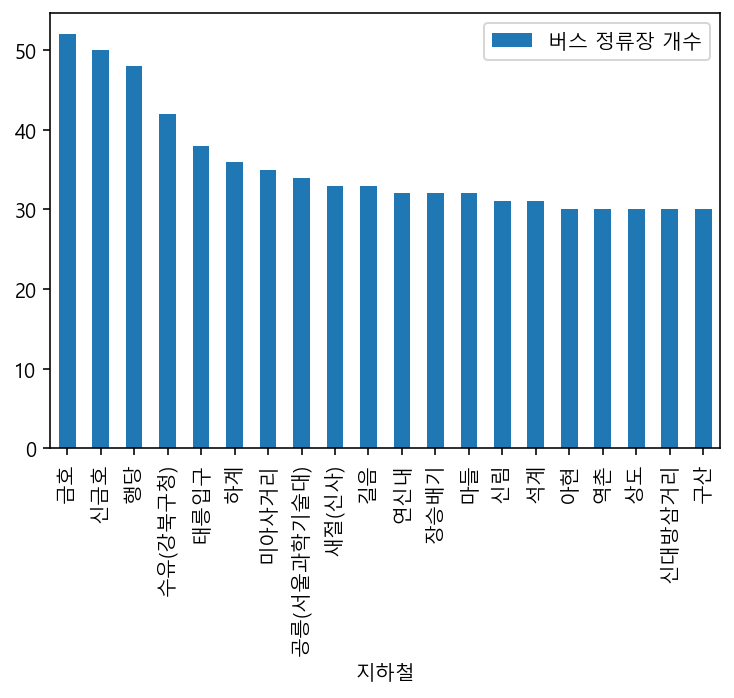

In [240]:
bus_count_sort.plot(kind = "bar")

## 서울시 30분 지하철 이용

In [241]:
## 지하철 데이터 21년도 합쳐준 것,(데이터가 좀다름, 위 지하철 위치 데이터와 이름, 개수가 좀 다름, 일단 진행)

In [279]:
SUBWAY_total = pd.read_excel('./SUBWAY_total.xlsx', index_col = False)
SUBWAY_total

,Unnamed: 0,지하철,노선명,총승객수,터미널
0,0,4.19민주묘지,우이신설선,1754924,0
1,1,가능,경원선,3989889,0
2,2,가락시장,3호선,5257751,0
3,3,가락시장,8호선,4845038,0
4,4,가산디지털단지,7호선,25568604,0
...,...,...,...,...,...
606,606,회룡,경원선,7617222,0
607,607,회현(남대문시장),4호선,14146864,0
608,608,효창공원앞,6호선,3938867,0
609,609,효창공원앞,경의선,1816377,0


In [280]:
SUBWAY_total = SUBWAY_total[['지하철', '노선명', '총승객수',	'터미널']]

In [281]:
SUBWAY_total

,지하철,노선명,총승객수,터미널
0,4.19민주묘지,우이신설선,1754924,0
1,가능,경원선,3989889,0
2,가락시장,3호선,5257751,0
3,가락시장,8호선,4845038,0
4,가산디지털단지,7호선,25568604,0
...,...,...,...,...
606,회룡,경원선,7617222,0
607,회현(남대문시장),4호선,14146864,0
608,효창공원앞,6호선,3938867,0
609,효창공원앞,경의선,1816377,0


In [247]:
## 19년도 지하철 위치데이터 지하철 역 680개
## 열린데이터 광장 승객수 데이터 지하철 역 610

In [248]:
SUBWAY_total = SUBWAY_total[['역명', '노선명', '총승객수']]

In [249]:
SUBWAY_total

,역명,노선명,총승객수
0,4.19민주묘지,우이신설선,1754924
1,가능,경원선,3989889
2,가락시장,3호선,5257751
3,가락시장,8호선,4845038
4,가산디지털단지,7호선,25568604
...,...,...,...
606,회룡,경원선,7617222
607,회현(남대문시장),4호선,14146864
608,효창공원앞,6호선,3938867
609,효창공원앞,경의선,1816377


In [259]:
SUBWAY_total.to_csv('SUBWAY_total.csv')

In [251]:
# 이용인원과 버스정류장수 합치기

In [282]:
SUBWAY_total = SUBWAY_total.rename(columns = {'역명':'지하철'})
SUBWAY_total

,지하철,노선명,총승객수,터미널
0,4.19민주묘지,우이신설선,1754924,0
1,가능,경원선,3989889,0
2,가락시장,3호선,5257751,0
3,가락시장,8호선,4845038,0
4,가산디지털단지,7호선,25568604,0
...,...,...,...,...
606,회룡,경원선,7617222,0
607,회현(남대문시장),4호선,14146864,0
608,효창공원앞,6호선,3938867,0
609,효창공원앞,경의선,1816377,0


In [253]:
SUBWAY_total = SUBWAY_total.groupby(['지하철']).sum()

In [254]:
subway_bus = pd.merge(SUBWAY_total, bus_count, how='outer', on='지하철')

In [255]:
subway_bus = subway_bus.drop_duplicates(['총승객수'], keep='first')

In [256]:
subway_bus = subway_bus.dropna(how='any')

In [257]:
subway_bus

,총승객수,버스 정류장 개수
지하철,,
강동,10890334,17.0
거여,5002504,12.0
공릉(서울과학기술대),7159781,34.0
광나루(장신대),7624126,19.0
광명사거리,13655197,1.0
...,...,...
하계,10280361,36.0
행당,4642287,48.0
홍제,10242218,26.0


In [258]:
# 전체를 하나 na, 중복값 빼주고 하나 상관관계 같음
subway_bus.corr()

,총승객수,버스 정류장 개수
총승객수,1.000000,0.216751
버스 정류장 개수,0.216751,1.000000


In [203]:
# 시각화 - 버스정류장 개수 상위 20개의 총승객수 확인

In [204]:
subway_plot = subway_bus.sort_values('버스 정류장 개수', ascending = False).head(20)

In [205]:
subway_plot

,총승객수,버스 정류장 개수
지하철,,
광흥창(서강),5125205,49.0
효창공원앞,5755244,34.0
공덕,22101343,34.0
보라매,5787510,33.0
방배,10062828,31.0
서울역,41783872,31.0
충정로(경기대입구),8585790,31.0
구로디지털단지,35106106,30.0
마포,8235301,29.0


In [206]:
subway_plot

,총승객수,버스 정류장 개수
지하철,,
광흥창(서강),5125205,49.0
효창공원앞,5755244,34.0
공덕,22101343,34.0
보라매,5787510,33.0
방배,10062828,31.0
서울역,41783872,31.0
충정로(경기대입구),8585790,31.0
구로디지털단지,35106106,30.0
마포,8235301,29.0


<AxesSubplot:xlabel='지하철'>

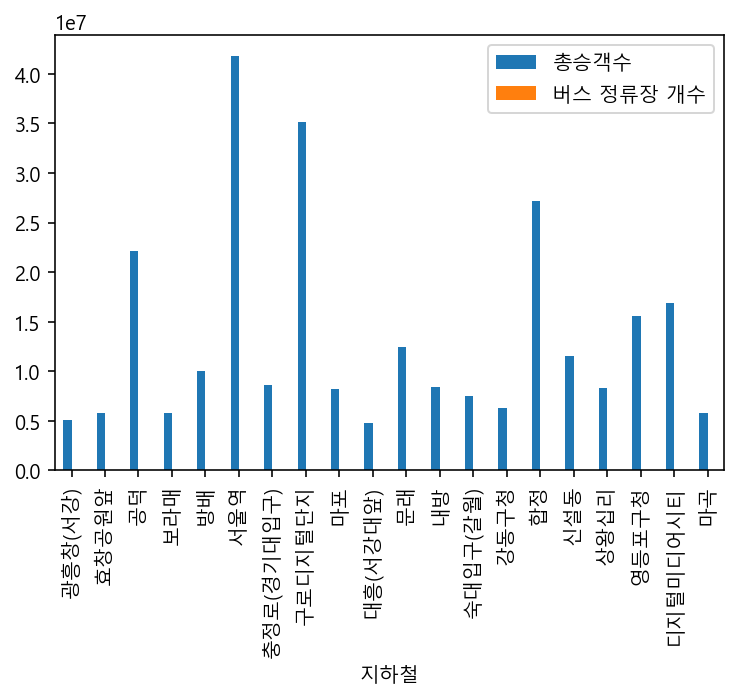

In [207]:
# 버스 정류장 개수가 큰 순서대로의 총승객수 시각화
subway_plot.plot(kind = "bar")

## 우수중소기업 공간데이터

In [314]:
EXC =  pd.read_csv("data/EXC_df.csv")
EXC

,SMLPZ_ID,DEC_SE,CMPNY_NM,RPRSNTV_NM,INDUTY,FOND_DATE,ADDRES,TM_X,TM_Y
0,1,하이브랜드서울기업,벨금속공업㈜,이희평,날붙이 제조업,1978-01-12,서초구 효령로68길 92 (서초동),201762.893208,542899.588742
1,2,하이브랜드서울기업,㈜일성,지영배,액체 펌프 제조업,2000-01-03,구로구 경인로63길 21-6,189818.338312,545438.678543
2,3,하이브랜드서울기업,이앤에이치㈜,박대전,건설업본사,1998-05-01,"성동구 성수이로 7길 27, 701 (서울숲 코오롱디지털타워2차)",204724.207199,549119.988156
3,4,하이브랜드서울기업,㈜지넷시스템,서형덕,기타 무선 통신장비 제조업,1998-02-10,금천구 가산 디지털 2로 98 롯데아이티 캐슬 2동 6층,189481.128053,541984.760645
4,5,하이브랜드서울기업,㈜스페이스링크,양희식,컴퓨터시스템 통합 자문 및 구축 서비스업,1997-06-05,"마포구 매봉산로 37, 9층 905호 (DMC 산학협력연구센터)",190337.914065,552950.945367
...,...,...,...,...,...,...,...,...,...
684,685,서울형강소기업,한그린테크,김대현,제조업,2010-09-07,성북구 종암로 29,203178.254223,554812.267161
685,686,서울형강소기업,현대와코텍,신용성,제조,2004-05-20,노원구 노원로 15길 10 하계테크노타운 A-301,206350.871325,560260.897705
686,687,서울형강소기업,호스트센터(주),차성진,컴퓨터시스템 통합 자문 및 구축 서비스업,2002-05-23,"서초구 법원로3길 19, 3층(서초동, 양지원빌딩)",200746.667982,543731.172025
687,688,서울형강소기업,후스타일,김진석,"도소매, 제조, 무역, 전자상거래업, 건강식품 등",2005-08-30,금천구 가산디지털2로 115,189332.794053,542110.461550


In [315]:
# 필요 컬럼 선택

EXC = EXC[['DEC_SE', 'ADDRES', 'TM_X', 'TM_Y']]
EXC.head()

,DEC_SE,ADDRES,TM_X,TM_Y
0,하이브랜드서울기업,서초구 효령로68길 92 (서초동),201762.893208,542899.588742
1,하이브랜드서울기업,구로구 경인로63길 21-6,189818.338312,545438.678543
2,하이브랜드서울기업,"성동구 성수이로 7길 27, 701 (서울숲 코오롱디지털타워2차)",204724.207199,549119.988156
3,하이브랜드서울기업,금천구 가산 디지털 2로 98 롯데아이티 캐슬 2동 6층,189481.128053,541984.760645
4,하이브랜드서울기업,"마포구 매봉산로 37, 9층 905호 (DMC 산학협력연구센터)",190337.914065,552950.945367


In [316]:
# TM -> 위경도 좌표 변환을 위해 선택

EXC_xy = EXC[['TM_X', 'TM_Y']]

In [317]:
# TM -> 위경도 변환 함수

def project_array(coord, p1_type, p2_type):
    """
    좌표계 변환 함수
    - coord: x, y 좌표 정보가 담긴 NumPy Array
    - p1_type: 입력 좌표계 정보 ex) epsg:5186
    - p2_type: 출력 좌표계 정보 ex) epsg:4326
    """
    p1 = pyproj.Proj(init=p1_type)
    p2 = pyproj.Proj(init=p2_type)
    fx, fy = pyproj.transform(p1, p2, coord[:, 0], coord[:, 1])
    return np.dstack([fx, fy])[0]

In [318]:
coord = np.array(EXC_xy)
coord.shape
#coord[:5]

(689, 2)

In [319]:
# 좌표계 정보 설정
p1_type = "epsg:5186"
p2_type = "epsg:4326"

# project_array() 함수 실행
result_imt = project_array(coord, p1_type, p2_type)
result_imt[:5]

array([[127.01993265,  37.48554134],
       [126.88484315,  37.50836426],
       [127.05345553,  37.54157698],
       [126.88107858,  37.4772405 ],
       [126.89062082,  37.57605522]])

In [328]:
EXC["위도"] = result_imt[:, 1]
EXC["경도"] = result_imt[:, 0]
EXC.to_csv('EXC.csv')

In [329]:
EXC

,DEC_SE,ADDRES,TM_X,TM_Y,위도,경도
0,하이브랜드서울기업,서초구 효령로68길 92 (서초동),201762.893208,542899.588742,37.485541,127.019933
1,하이브랜드서울기업,구로구 경인로63길 21-6,189818.338312,545438.678543,37.508364,126.884843
2,하이브랜드서울기업,"성동구 성수이로 7길 27, 701 (서울숲 코오롱디지털타워2차)",204724.207199,549119.988156,37.541577,127.053456
3,하이브랜드서울기업,금천구 가산 디지털 2로 98 롯데아이티 캐슬 2동 6층,189481.128053,541984.760645,37.477240,126.881079
4,하이브랜드서울기업,"마포구 매봉산로 37, 9층 905호 (DMC 산학협력연구센터)",190337.914065,552950.945367,37.576055,126.890621
...,...,...,...,...,...,...
684,서울형강소기업,성북구 종암로 29,203178.254223,554812.267161,37.592871,127.035987
685,서울형강소기업,노원구 노원로 15길 10 하계테크노타운 A-301,206350.871325,560260.897705,37.641946,127.071958
686,서울형강소기업,"서초구 법원로3길 19, 3층(서초동, 양지원빌딩)",200746.667982,543731.172025,37.493035,127.008443
687,서울형강소기업,금천구 가산디지털2로 115,189332.794053,542110.461550,37.478371,126.879400


In [321]:
EXC_result = np.array(EXC[['위도', '경도']])
EXC_result

array([[ 37.48554134, 127.01993265],
       [ 37.50836426, 126.88484315],
       [ 37.54157698, 127.05345553],
       ...,
       [ 37.49303535, 127.00844326],
       [ 37.47837137, 126.87939977],
       [ 37.52363997, 127.0300339 ]])

In [322]:
# 역별로 중소기업 시설의 개수

print("중소기업\n")
sb2 = []
i = 0
count_all = 0
for a, b in result_sub:
    lyon = (a, b)    # 실제 지하철 역의 위도 경도값 설정
    count = 0 
    for c, d in EXC_result:
        paris=(c, d)    # 실제 시설의 위도 경도값 설정 
        A = haversine(lyon, paris) < 0.5   # haversine이용해서 지하철역의 반경 1km내에 위치하는 시설 찾기
        if A is True:
            count += 1
            count_all += 1
    print(name[i], '->', count, '개')
    print("="*30)
    i += 1
    sb2.append(count)
    
print(count_all)

중소기업

가산디지털단지 -> 0 개
강남 -> 0 개
강남구청 -> 0 개
경복궁(정부서울청사) -> 0 개
광화문(세종문화회관) -> 0 개
교대(법원.검찰청) -> 0 개
남부터미널(예술의전당) -> 0 개
논현 -> 0 개
동대문역사문화공원(DDP) -> 0 개
동대입구 -> 0 개
동묘앞 -> 0 개
명동 -> 0 개
삼각지 -> 0 개
삼성(무역센터) -> 0 개
서대문 -> 0 개
서초 -> 0 개
선릉 -> 0 개
시청 -> 0 개
신사 -> 0 개
신용산 -> 0 개
안국 -> 0 개
압구정 -> 0 개
양재(서초구청) -> 0 개
여의나루 -> 0 개
여의도 -> 0 개
역삼 -> 0 개
을지로3가 -> 0 개
을지로4가 -> 0 개
을지로입구 -> 0 개
종각 -> 0 개
종로3가 -> 0 개
종로5가 -> 0 개
청담 -> 0 개
충무로 -> 0 개
학동 -> 0 개
한강진 -> 0 개
한양대 -> 0 개
회현(남대문시장) -> 0 개
0


In [323]:
i = 0
sb = []
for a, b in result_sub:
    sb.append(name[i])
    i+= 1
sb[:5]

['가산디지털단지', '강남', '강남구청', '경복궁(정부서울청사)', '광화문(세종문화회관)']

In [324]:
businesses = pd.DataFrame(data = list(zip(sb, sb2)), columns = ['지하철','중소기업 개수'])

In [325]:
businesses.to_csv('businesses')

In [80]:
# 중소기업, 버스 승하차 인원 더하기

In [81]:
subway_businesses = pd.merge(SUBWAY_total, businesses, how='outer', on='지하철')

In [82]:
subway_businesses = subway_businesses.drop_duplicates(['총승객수'], keep='first')

In [83]:
subway_businesses

,지하철,노선명,총승객수,중소기업 개수
0,4.19민주묘지,우이신설선,1754924.0,NaN
1,가능,경원선,3989889.0,0.0
2,가락시장,3호선,5257751.0,3.0
4,가락시장,8호선,4845038.0,3.0
6,가산디지털단지,7호선,25568604.0,65.0
...,...,...,...,...
765,회현(남대문시장),4호선,14146864.0,NaN
766,효창공원앞,6호선,3938867.0,1.0
768,효창공원앞,경의선,1816377.0,1.0
770,흑석(중앙대입구),9호선,4732378.0,NaN


In [84]:
subway_businesses.corr()

,총승객수,중소기업 개수
총승객수,1.000000,0.283361
중소기업 개수,0.283361,1.000000


## 대학교

In [7]:
college

,UNIV_ID,STDR_YEAR,ELSM,UNIV_CD,UNIV_NM,BNHH_SN,UNIV_STTUS,LC,FOND,OLD_ZIP,ADRES,ENRL_ST_SM,ENRL_ST_CN,TMPABSSKL,TCHER_CN,TM_X,TM_Y
0,48110001.0,202004,대학원,,가톨릭대학교교회음악대학원,제3캠퍼스,기존,서울,사립,03083,"서울특별시종로구창경궁로296-12(혜화동,가톨릭대학교성신교정)",0.0,0.0,0.0,0.0,200377.582826,554053.289913
1,48110002.0,202004,대학원,,가톨릭대학교보건대학원,제2캠퍼스,기존,서울,사립,06591,"서울특별시서초구반포대로222(반포동,가톨릭대학교성의교정)",0.0,0.0,0.0,0.0,200563.146912,544622.519540
2,48110003.0,202004,대학원,,가톨릭대학교생명대학원,제2캠퍼스,기존,서울,사립,06591,"서울특별시서초구반포대로222(반포동,가톨릭대학교성의교정)",0.0,0.0,0.0,0.0,200563.146912,544622.519540
3,48110004.0,202004,대학원,,가톨릭대학교의료경영대학원,제2캠퍼스,기존,서울,사립,06591,"서울특별시서초구반포대로222(반포동,가톨릭대학교성의교정)",0.0,0.0,0.0,0.0,200563.146912,544622.519540
4,48110005.0,202004,대학원,,가톨릭대학교의학전문대학원,제2캠퍼스,폐교,서울,사립,06591,"서울특별시서초구반포대로222(반포동,가톨릭대학교성의교정)",0.0,0.0,0.0,0.0,200563.146912,544622.519540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,48110482.0,202004,대학원,,홍익대학교영상·커뮤니케이션대학원,본교,신설,서울,사립,04066,서울특별시마포구와우산로94(상수동)대학원교학팀,0.0,0.0,0.0,0.0,193430.815156,550136.749210
482,48110483.0,202004,대학원,,홍익대학교영상대학원,본교,폐교,서울,사립,04066,"서울특별시마포구와우산로94(상수동,홍익대학교)",0.0,0.0,0.0,0.0,193430.815156,550136.749210
483,48110484.0,202004,대학원,,홍익대학교패션대학원,본교,기존,서울,사립,04066,"서울특별시마포구와우산로94(상수동,홍익대학교)",0.0,0.0,0.0,0.0,193430.815156,550136.749210
484,48110485.0,202004,대학,7002340,홍익대학교,본교,기존,서울,사립,04066,"서울특별시마포구와우산로94(상수동,홍익대학교)",16877.0,12340.0,4537.0,557.0,193430.815156,550136.749210


In [8]:
college_s = college[["TM_X", "TM_Y"]]
college_s

,TM_X,TM_Y
0,200377.582826,554053.289913
1,200563.146912,544622.519540
2,200563.146912,544622.519540
3,200563.146912,544622.519540
4,200563.146912,544622.519540
...,...,...
481,193430.815156,550136.749210
482,193430.815156,550136.749210
483,193430.815156,550136.749210
484,193430.815156,550136.749210


In [11]:
coord = np.array(college_s)

# 좌표계 정보 설정
p1_type = "epsg:5186"
p2_type = "epsg:4326"

# project_array() 함수 실행
result_imt = project_array(coord, p1_type, p2_type)
result_imt[:5]

college["위도"] = result_imt[:, 1]
college["경도"] = result_imt[:, 0]

In [12]:
college

,UNIV_ID,STDR_YEAR,ELSM,UNIV_CD,UNIV_NM,BNHH_SN,UNIV_STTUS,LC,FOND,OLD_ZIP,ADRES,ENRL_ST_SM,ENRL_ST_CN,TMPABSSKL,TCHER_CN,TM_X,TM_Y,위도,경도
0,48110001.0,202004,대학원,,가톨릭대학교교회음악대학원,제3캠퍼스,기존,서울,사립,03083,"서울특별시종로구창경궁로296-12(혜화동,가톨릭대학교성신교정)",0.0,0.0,0.0,0.0,200377.582826,554053.289913,37.586038,127.004275
1,48110002.0,202004,대학원,,가톨릭대학교보건대학원,제2캠퍼스,기존,서울,사립,06591,"서울특별시서초구반포대로222(반포동,가톨릭대학교성의교정)",0.0,0.0,0.0,0.0,200563.146912,544622.519540,37.501067,127.006369
2,48110003.0,202004,대학원,,가톨릭대학교생명대학원,제2캠퍼스,기존,서울,사립,06591,"서울특별시서초구반포대로222(반포동,가톨릭대학교성의교정)",0.0,0.0,0.0,0.0,200563.146912,544622.519540,37.501067,127.006369
3,48110004.0,202004,대학원,,가톨릭대학교의료경영대학원,제2캠퍼스,기존,서울,사립,06591,"서울특별시서초구반포대로222(반포동,가톨릭대학교성의교정)",0.0,0.0,0.0,0.0,200563.146912,544622.519540,37.501067,127.006369
4,48110005.0,202004,대학원,,가톨릭대학교의학전문대학원,제2캠퍼스,폐교,서울,사립,06591,"서울특별시서초구반포대로222(반포동,가톨릭대학교성의교정)",0.0,0.0,0.0,0.0,200563.146912,544622.519540,37.501067,127.006369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,48110482.0,202004,대학원,,홍익대학교영상·커뮤니케이션대학원,본교,신설,서울,사립,04066,서울특별시마포구와우산로94(상수동)대학원교학팀,0.0,0.0,0.0,0.0,193430.815156,550136.749210,37.550727,126.925659
482,48110483.0,202004,대학원,,홍익대학교영상대학원,본교,폐교,서울,사립,04066,"서울특별시마포구와우산로94(상수동,홍익대학교)",0.0,0.0,0.0,0.0,193430.815156,550136.749210,37.550727,126.925659
483,48110484.0,202004,대학원,,홍익대학교패션대학원,본교,기존,서울,사립,04066,"서울특별시마포구와우산로94(상수동,홍익대학교)",0.0,0.0,0.0,0.0,193430.815156,550136.749210,37.550727,126.925659
484,48110485.0,202004,대학,7002340,홍익대학교,본교,기존,서울,사립,04066,"서울특별시마포구와우산로94(상수동,홍익대학교)",16877.0,12340.0,4537.0,557.0,193430.815156,550136.749210,37.550727,126.925659


In [13]:
college_map = g.Map(location =[37.613333,127.030049],zoom_start = 12)
# 시각화
for item in college.index:
    lat = college.loc[item, '위도']
    long = college.loc[item, '경도']
    g.Marker([lat, long],
                        fill = True).add_to(college_map)
college_map

In [16]:
result_sub = np.array(STATN19[['위도', '경도']])
college_spare = np.array(college[['위도', '경도']])

In [ ]:
# 역별 대학교 수
print("대학교 \n")
college_near = []
i = 0
for a, b in result_sub:
    lyon = (a, b)       # 실제 지하철 역의 위도 경도값 설정
    count = 0 
    for c, d in college_spare:
        paris=(c, d)                  # 실제 시설의 위도 경도값 설정
        A = haversine(lyon, paris) < 0.5    # 지하철역의 위치값을 기준으로 반경 1km내에 포함된 시설 찾기
        if A is True:
            count += 1
    print(name[i], '->', count, '개')
    print("="*30)
    i += 1
    college_near.append(count)

In [ ]:
college_near

이 데이터도 적당히 줄긴했지만 같은 학교에 여러게 표시되어있음, 인원수 데이터도 따로 없어서 의미 없음

굳이 의미를 찾는다면 역에 몇개의 대학교가 있는지 확인할 수 있다는 정도.

## 행정동 단위 인구

해당 지하철 역 주소의 행정동을 기준으로 삼았다.

행정동 

공부(公簿)상의 법정동(法定洞)처럼 자연부락을 바탕으로 하였거나 오랜 전통을 지닌 동과는 달리, 행정관청이 관할구역의 넓이보다는 주로 인구의 증감에 따라 인구가 많은 하나의 법정동에 여러 행정동을 설정하여 동행정을 따로따로 보게 한다든지, 인구가 적은 여러 법정동을 묶어 하나의 행정동을 두기도 한다. 따라서 행정동은 동사무소를 단위로 하는 행정구역이라고 할 수 있으며, 그 설정은 시조례로 정한다.

일반 주소는 법적동

In [8]:
population

,STD_YM,ADMI_CD,ADMI_NM,SEXDSTN_CD,AGRDE_CD,RSPOP_CNT,CTY_NM
0,`202101`,`11110530`,`사직동`,`1`,`0004`,`112`,`종로구`
1,`202101`,`11350670`,`상계5동`,`1`,`0004`,`223`,`노원구`
2,`202101`,`11440690`,`망원1동`,`1`,`0004`,`240`,`마포구`
3,`202101`,`11560670`,`신길5동`,`1`,`0004`,`205`,`영등포구`
4,`202101`,`11410685`,`홍은2동`,`1`,`0004`,`291`,`서대문구`
...,...,...,...,...,...,...,...
195633,`202112`,`11620605`,`은천동`,`2`,`I00`,`2`,`관악구`
195634,`202112`,`11320710`,`방학3동`,`2`,`I00`,`5`,`도봉구`
195635,`202112`,`11470540`,`목4동`,`2`,`I00`,`3`,`양천구`
195636,`202112`,`11215870`,`구의3동`,`2`,`I00`,`3`,`광진구`


In [9]:
# value값에 쓰잘데기없는 `기호 없애기

population = population.apply(lambda x: x.str.strip("`"), axis = 0)
population = population[['STD_YM','ADMI_NM','SEXDSTN_CD','AGRDE_CD','RSPOP_CNT','CTY_NM']]
population

,STD_YM,ADMI_NM,SEXDSTN_CD,AGRDE_CD,RSPOP_CNT,CTY_NM
0,202101,사직동,1,0004,112,종로구
1,202101,상계5동,1,0004,223,노원구
2,202101,망원1동,1,0004,240,마포구
3,202101,신길5동,1,0004,205,영등포구
4,202101,홍은2동,1,0004,291,서대문구
...,...,...,...,...,...,...
195633,202112,은천동,2,I00,2,관악구
195634,202112,방학3동,2,I00,5,도봉구
195635,202112,목4동,2,I00,3,양천구
195636,202112,구의3동,2,I00,3,광진구


In [10]:
# 인구가 object 형인것 확인
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195638 entries, 0 to 195637
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   STD_YM      195636 non-null  object
 1   ADMI_NM     195636 non-null  object
 2   SEXDSTN_CD  195636 non-null  object
 3   AGRDE_CD    195636 non-null  object
 4   RSPOP_CNT   195636 non-null  object
 5   CTY_NM      195636 non-null  object
dtypes: object(6)
memory usage: 9.0+ MB


In [11]:
# na 값이 있는 것을 확인 -> 삭제
population.isna().sum()

STD_YM        2
ADMI_NM       2
SEXDSTN_CD    2
AGRDE_CD      2
RSPOP_CNT     2
CTY_NM        2
dtype: int64

In [12]:
population = population.dropna()

In [13]:
population = population.astype({'RSPOP_CNT':'int', 'STD_YM':'int', 'SEXDSTN_CD':'int'})

In [14]:
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195636 entries, 0 to 195637
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   STD_YM      195636 non-null  int32 
 1   ADMI_NM     195636 non-null  object
 2   SEXDSTN_CD  195636 non-null  int32 
 3   AGRDE_CD    195636 non-null  object
 4   RSPOP_CNT   195636 non-null  int32 
 5   CTY_NM      195636 non-null  object
dtypes: int32(3), object(3)
memory usage: 8.2+ MB


In [15]:
# 월별 동별 인구수 그룹바이,

# 남/녀, 나이별 - 굳이 안해주고 진행

# 지하철 이용 가능? 인구

In [16]:
population_m = population.groupby(['STD_YM','ADMI_NM']).sum('RSPOP_CNT')[['RSPOP_CNT']]

In [17]:
population_m = population_m.reset_index()

In [18]:
population_m 

,STD_YM,ADMI_NM,RSPOP_CNT
0,202101,가락1동,27653
1,202101,가락2동,32927
2,202101,가락본동,27029
3,202101,가리봉동,9274
4,202101,가산동,23162
...,...,...,...
4642,202112,효창동,10037
4643,202112,후암동,16833
4644,202112,휘경1동,13927
4645,202112,휘경2동,24115


In [19]:
#population_m.to_csv('population_m.csv')

# insight

1. 그룹화의 중요성 - 승하차 인원이 어느 호선에 따라 달라지는 것이 아닌 특정 역의 주변에 어떤 시설이 있는지에 따라 달라짐 
2. 그룹별 역 확인 - 그룹별로 어떤 역이 어느 그룹에 포함되는지 확인
3. 데이터에 문제가 있을시 사용 불가.
4. 역 주변 반경 500m에 버스 정류장 개수가 환승과 상관 있을 것이라 예상
5. 지하철 수요 예측의 중요한 변수중 거주인구 - 행정동 단위 인구데이터를 어떤 식으로 사용해야 할까?

5-1. 유동인구 데이터를 활용하여 특정 역에 유동인구가 얼마나 되는지 확인

-> 유동인구가 거주인구는 아님, 또한 특정역에 내려서 버스로 환승을 할 수도 있기에 정확하지 않음

5-2. 지하철 반경 500m에 포함되는 행정동 면적별 비율을 확인하여 각 행정동 인구의 비율로 합산